In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import wrds

db = wrds.Connection(wrds='tuomas_pkknn')

Enter your WRDS username [tuomasp]:tuomas_pkknn
Enter your password:········
WRDS recommends setting up a .pgpass file.
Create .pgpass file now [y/n]?: n
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


In [2]:
stocks = db.raw_sql("select date, vwretd "
                    "from crsp.msi "
                    "where date>='1960-01-01' "
                    "and date<='2022-12-31'",
                    date_cols=['date'])

bonds = db.raw_sql("select caldt, b2ret "
                    "from crsp.mcti "
                    "where caldt>='1960-01-01' "
                    "and caldt<='2022-12-31'",
                    date_cols=['caldt'])

In [3]:
# (a)
bonds = bonds.rename(columns={"caldt": "date"})
returns = pd.merge(stocks, bonds, on = "date")
returns["date"] = pd.to_datetime(returns["date"])

# risk-free rate, weights of stocks and bonds
r_f = 0.01
w_s = 0.6
w_b = 0.4

# annualized means and variances (and standard deviations)
mean_stocks = 12 * returns["vwretd"].mean()
var_stocks = 12 * returns["vwretd"].var()
std_stocks = np.sqrt(var_stocks)
mean_bonds = 12 * returns["b2ret"].mean()
var_bonds = 12 * returns["b2ret"].var()
std_bonds = np.sqrt(var_bonds)

cov_sb = returns.cov()["b2ret"]["vwretd"]

mean_pf = w_s * mean_stocks + w_b * mean_bonds
var_pf = w_s**2 * var_stocks + w_b**2 * var_bonds
std_pf = np.sqrt(var_pf)
sr_pf = (mean_pf - r_f) / std_pf

print("For the 60/40 portfolio, the mean is {:.4f}, the standard deviation is {:.4f} and the Sharpe ratio is {:.4f}.".format(mean_pf, std_pf, sr_pf))

x = np.linspace(0,1,1500)
R_p = x * mean_stocks + (1-x) * mean_bonds
std_p = np.sqrt(x**2 * var_stocks + (1-x)**2 * var_bonds + 2 * x * (1-x) * cov_sb)

# tangency PF
sharpe_ratio_arr_tang = (R_p - r_f) / std_p
sr_tang = np.amax(sharpe_ratio_arr_tang)
tang_index = np.argmax(sharpe_ratio_arr_tang)
std_tang = std_p[tang_index]
mean_tang = std_tang * sr_tang + r_f

print("For the tangency portfolio, the mean is {:.4f}, the standard deviation is {:.4f} and the Sharpe ratio is {:.4f}.".format(mean_tang, std_tang, sr_tang))

For the 60/40 portfolio, the mean is 0.0850, the standard deviation is 0.0932 and the Sharpe ratio is 0.8040.
For the tangency portfolio, the mean is 0.0571, the standard deviation is 0.0283 and the Sharpe ratio is 1.6655.


For the Risk-Parity portfolio, the mean is 0.0617, the standard deviation is 0.0336 and the Sharpe ratio is 1.5354.
For the leveraged Risk-Parity portfolio, the mean is 0.1532, the standard deviation is 0.0932 and the Sharpe ratio is 0.5541.


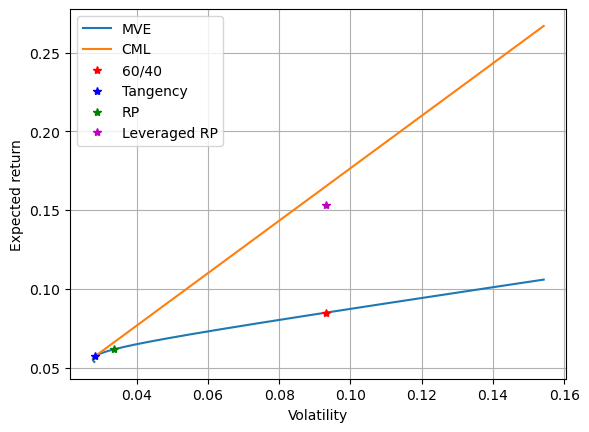

In [4]:
# (b)
# basic risk-parity PF
inv_std_s = 1/std_stocks
inv_std_b = 1/std_bonds
total_w_rp = inv_std_s + inv_std_b
w_rp_s = inv_std_s / total_w_rp
w_rp_b = inv_std_b / total_w_rp

mean_rp = w_rp_s * mean_stocks + w_rp_b * mean_bonds
var_rp = w_rp_s**2 * var_stocks + w_rp_b**2 * var_bonds
std_rp = np.sqrt(var_rp)
sr_rp = (mean_rp - r_f) / std_rp

print("For the Risk-Parity portfolio, the mean is {:.4f}, the standard deviation is {:.4f} and the Sharpe ratio is {:.4f}.".format(mean_rp, std_rp, sr_rp))

leverage_cst = std_pf / std_rp
w_rpl_s = w_rp_s * leverage_cst
w_rpl_b = w_rp_b * leverage_cst

# due to leverage
mean_rpl = w_rpl_s * mean_stocks + w_rpl_b * mean_bonds - (w_rpl_s + w_rpl_b - w_rp_s - w_rp_b) * r_f
var_rpl = w_rpl_s**2 * var_stocks + w_rpl_b**2 * var_bonds
std_rpl = np.sqrt(var_rpl)
sr_rpl = (mean_rp - r_f) / std_rpl

print("For the leveraged Risk-Parity portfolio, the mean is {:.4f}, the standard deviation is {:.4f} and the Sharpe ratio is {:.4f}.".format(mean_rpl, std_rpl, sr_rpl))

x_plot = std_p
y_plot = sr_tang * x_plot + r_f

plt.plot(std_p, R_p, label = 'MVE')
plt.xlabel('Volatility')
plt.ylabel('Expected return')

plt.plot(x_plot, y_plot, label = 'CML')

plt.plot(std_pf, mean_pf, 'r*', label = '60/40')
plt.plot(std_tang, mean_tang, 'b*', label = 'Tangency')
plt.plot(std_rp, mean_rp, 'g*', label = 'RP')
plt.plot(std_rpl, mean_rpl, 'm*', label = 'Leveraged RP')

plt.grid()

plt.legend()
plt.show()

### Problem 3b)
The difference between the RP and the RP-levered portfolio performances is explained by the use of leverage (and thus indirectly the risk appetite of the investors). Indeed, as the leverage goes up, both the volatility (due to larger weight coefficients on the assets) and the returns go up too, as the additional returns are more than enough to cover the 1% risk-free rate.

### Problem 3c)
The difference could be explained by the fact that the portfolios on the efficient frontier are linear combinations of stocks and bonds. However, due to the use of rolling averages of the data over 3-year periods in AFP, we get a portfolio which is not really a linear combination anymore (unlike our portfolio, built over the entire time period) and thus does not lie on the efficient frontier.
Another factor could be the differences in data over time, as the Figure 2 in AFP takes into account data between 1926 and 2010 and our computations have been done on data between 1960 and 2022. The returns and volatility of stocks and bonds have greatly varied between these timeframes which explains the difference.

For the 60/40 portfolio in 1960-1990, the mean is 0.0951, the standard deviation is 0.0942 and the Sharpe ratio is 0.9029.
For the tangency portfolio in 1960-1990, the mean is 0.0747, the standard deviation is 0.0348 and the Sharpe ratio is 1.8589.
For the optimal portfolio of the mean-variance investor with 60/40 volatility in 1960-1990, the mean is 0.1852, the standard deviation is 0.0942 and the Sharpe ratio is 1.8589.
For the Risk-Parity portfolio in 1960-1990, the mean is 0.0790, the standard deviation is 0.0406 and the Sharpe ratio is 1.6982.
For the leveraged Risk-Parity portfolio in 1960-1990, the mean is 0.1700, the standard deviation is 0.0942 and the Sharpe ratio is 0.7325.


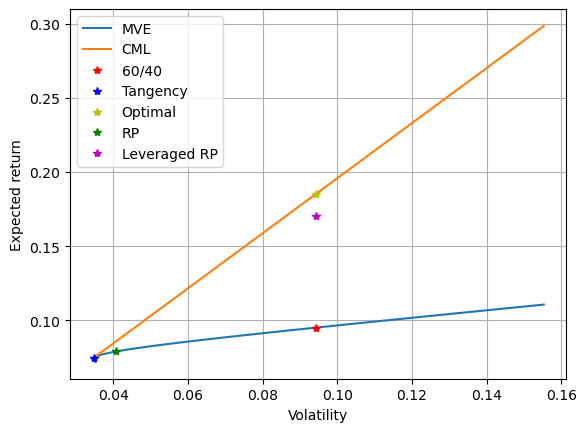

For the 60/40 portfolio in 1990-2022, the mean is 0.0758, the standard deviation is 0.0924 and the Sharpe ratio is 0.7120.
For the tangency portfolio in 1990-2022, the mean is 0.0401, the standard deviation is 0.0188 and the Sharpe ratio is 1.5993.
For the optimal portfolio of the mean-variance investor with 60/40 volatility in 1990-2022, the mean is 0.1578, the standard deviation is 0.0924 and the Sharpe ratio is 1.5993.
For the Risk-Parity portfolio in 1990-2022, the mean is 0.0439, the standard deviation is 0.0231 and the Sharpe ratio is 1.4668.
For the leveraged Risk-Parity portfolio in 1990-2022, the mean is 0.1455, the standard deviation is 0.0924 and the Sharpe ratio is 0.3672.


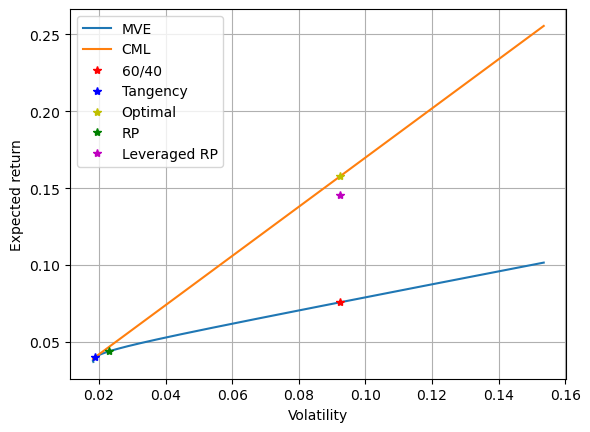

In [5]:
# (d)
mask_1d = (returns["date"] < '1990-1-1')
returns_1d = returns[mask_1d]
mask_2d = (returns["date"] >= '1990-1-1')
returns_2d = returns[mask_2d]

dict_ret = {
    "1960-1990": returns_1d,
    "1990-2022": returns_2d
}

for timeframe in dict_ret.keys():
    ret = dict_ret[timeframe]
    # annualized means and variances (and standard deviations)
    mean_stocks_d = 12 * ret["vwretd"].mean()
    var_stocks_d = 12 * ret["vwretd"].var()
    std_stocks_d = np.sqrt(var_stocks_d)
    mean_bonds_d = 12 * ret["b2ret"].mean()
    var_bonds_d = 12 * ret["b2ret"].var()
    std_bonds_d = np.sqrt(var_bonds_d)

    cov_sb_d = ret.cov()["b2ret"]["vwretd"]

    mean_pf_d = w_s * mean_stocks_d + w_b * mean_bonds_d
    var_pf_d = w_s**2 * var_stocks_d + w_b**2 * var_bonds_d
    std_pf_d = np.sqrt(var_pf_d)
    sr_pf_d = (mean_pf_d - r_f) / std_pf_d

    print("For the 60/40 portfolio in {}, the mean is {:.4f}, the standard deviation is {:.4f} and the Sharpe ratio is {:.4f}.".format(timeframe, mean_pf_d, std_pf_d, sr_pf_d))

    x_d = np.linspace(0,1,1500)
    R_p_d = x_d * mean_stocks_d + (1-x_d) * mean_bonds_d
    std_p_d = np.sqrt(x_d**2 * var_stocks_d + (1-x_d)**2 * var_bonds_d + 2 * x_d * (1-x_d) * cov_sb_d)

    # tangency PF
    sharpe_ratio_arr_tang_d = (R_p_d - r_f) / std_p_d
    sr_tang_d = np.amax(sharpe_ratio_arr_tang_d)
    tang_index_d = np.argmax(sharpe_ratio_arr_tang_d)
    std_tang_d = std_p_d[tang_index_d]
    mean_tang_d = std_tang_d * sr_tang_d + r_f

    print("For the tangency portfolio in {}, the mean is {:.4f}, the standard deviation is {:.4f} and the Sharpe ratio is {:.4f}.".format(timeframe, mean_tang_d, std_tang_d, sr_tang_d))
    
    # optimal PF for MV investor with 60/40 risk
    mean_opti_d = sr_tang_d * std_pf_d + r_f
    print("For the optimal portfolio of the mean-variance investor with 60/40 volatility in {}, the mean is {:.4f}, the standard deviation is {:.4f} and the Sharpe ratio is {:.4f}.".format(timeframe, mean_opti_d, std_pf_d, sr_tang_d))
    
    # basic risk-parity PF
    inv_std_s_d = 1/std_stocks_d
    inv_std_b_d = 1/std_bonds_d
    total_w_rp_d = inv_std_s_d + inv_std_b_d
    w_rp_s_d = inv_std_s_d / total_w_rp_d
    w_rp_b_d = inv_std_b_d / total_w_rp_d

    mean_rp_d = w_rp_s_d * mean_stocks_d + w_rp_b_d * mean_bonds_d
    var_rp_d = w_rp_s_d**2 * var_stocks_d + w_rp_b_d**2 * var_bonds_d
    std_rp_d = np.sqrt(var_rp_d)
    sr_rp_d = (mean_rp_d - r_f) / std_rp_d

    print("For the Risk-Parity portfolio in {}, the mean is {:.4f}, the standard deviation is {:.4f} and the Sharpe ratio is {:.4f}.".format(timeframe, mean_rp_d, std_rp_d, sr_rp_d))

    leverage_cst_d = std_pf_d / std_rp_d
    w_rpl_s_d = w_rp_s_d * leverage_cst_d
    w_rpl_b_d = w_rp_b_d * leverage_cst_d

    # due to leverage
    mean_rpl_d = w_rpl_s_d * mean_stocks_d + w_rpl_b_d * mean_bonds_d - (w_rpl_s_d + w_rpl_b_d - w_rp_s_d - w_rp_b_d) * r_f
    var_rpl_d = w_rpl_s_d**2 * var_stocks_d + w_rpl_b_d**2 * var_bonds_d
    std_rpl_d = np.sqrt(var_rpl_d)
    sr_rpl_d = (mean_rp_d - r_f) / std_rpl_d

    print("For the leveraged Risk-Parity portfolio in {}, the mean is {:.4f}, the standard deviation is {:.4f} and the Sharpe ratio is {:.4f}.".format(timeframe, mean_rpl_d, std_rpl_d, sr_rpl_d))

    x_plot_d = std_p_d
    y_plot_d = sr_tang_d * x_plot_d + r_f

    plt.plot(std_p_d, R_p_d, label = 'MVE')
    plt.xlabel('Volatility')
    plt.ylabel('Expected return')

    plt.plot(x_plot_d, y_plot_d, label = 'CML')

    plt.plot(std_pf_d, mean_pf_d, 'r*', label = '60/40')
    plt.plot(std_tang_d, mean_tang_d, 'b*', label = 'Tangency')
    plt.plot(std_pf_d, mean_opti_d, 'y*', label = 'Optimal')
    plt.plot(std_rp_d, mean_rp_d, 'g*', label = 'RP')
    plt.plot(std_rpl_d, mean_rpl_d, 'm*', label = 'Leveraged RP')

    plt.grid()

    plt.legend()
    plt.show()

### Problem 3d)
We can see that there are slight differences between the optimal portfolio and the leveraged RP portfolio. The returns of the leveraged RP portfolio are slightly below the ones of the optimal leveraged portfolio (closer to the efficient frontier).

This seems logical according to the paper's statement, explaining that the optimal portfolio (lying on the CML) does not take into account the extra risk brought by stocks that many want to avoid (especially with leverage), which the RP considers. Indeed, as it allocates the same amount of risk to stocks and bonds, it mitigates the huge risk difference, which in practice (even with leverage), is translated to slightly lower returns for a similar amount of risk, but which remain still way above the 60/40 portfolio returns. 

(However, we need to mention that for the RP strategy to be efficient, we indeed need leverage, otherwise other portfolio compositions are preferable.)